# Investigating the endothelial cells in the multiome atlas

In [1]:
here::i_am("Endothelium/01_investigating_endothelium.ipynb")

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(destiny))
suppressPackageStartupMessages(library(batchelor))
suppressPackageStartupMessages(library(uwot))


# Load default settings
source(here::here("settings.R"))
source(here::here("utils.R"))

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/code



In [2]:
## START TEST ##
args <- list()
args$sce <-file.path(io$basedir,"data/processed/rna/SingleCellExperiment.rds")
args$metadataRNA <- file.path(io$basedir,"results/rna/mapping/sample_metadata_after_mapping.txt.gz")
args$metadataATAC <- file.path(io$basedir, '/results/atac/archR/qc/sample_metadata_after_qc.txt.gz')
args$trajectory_name <- "endothelium"
args$celltype_label <- "celltype"
args$outdir <- file.path(io$basedir,paste0("results/", args$trajectory_name))

args$batch_variable = 'sample'
args$features = 3000
args$npcs <- 10
args$min_dist = 0.3
args$n_neighbors = 25
args$seed = 1234
args$sample <- c('E7.5_rep1','E7.5_rep2','E7.75_rep1','E8.0_rep1','E8.0_rep2','E8.5_rep1','E8.5_rep2','E8.75_rep1','E8.75_rep2')
## END TEST ##

# I/O
dir.create(args$outdir, showWarnings=F, recursive=T)

# Trajectory 
opts$celltypes = c("Haematoendothelial_progenitors",
                    "Endothelium")

BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 16

In [3]:
args$outdir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/endothelium"

In [3]:
##########################
## Load sample metadata ##
##########################

sample_metadata <- fread(args$metadataRNA) %>%
  .[pass_rnaQC==TRUE & doublet_call==FALSE] %>%
    merge(.,fread(args$metadataATAC)[,c('cell', 'pass_atacQC')], by='cell') %>%
    .[pass_atacQC==TRUE]

stopifnot(args$celltype_label%in%colnames(sample_metadata))
sample_metadata <- sample_metadata   %>%
  .[,celltype:=eval(as.name(args$celltype_label))] %>%
  .[celltype%in%opts$celltypes] %>%
  .[,celltype:=factor(celltype,levels=opts$celltypes)] %>%
  .[sample%in% args$sample]

table(sample_metadata$celltype)

# Save
fwrite(sample_metadata, file.path(args$outdir,sprintf("%s_sample_metadata.txt.gz",args$trajectory_name)))


Haematoendothelial_progenitors                    Endothelium 
                           913                            666 

In [4]:
#########################
## Load RNA expression ##
#########################
  
sce <- load_SingleCellExperiment(
  file = args$sce, 
  normalise = TRUE, 
  cells = sample_metadata$cell, 
  remove_non_expressed_genes = TRUE
)

colData(sce) <- sample_metadata %>% as.data.frame %>% tibble::column_to_rownames("cell") %>%
  .[colnames(sce),] %>% DataFrame()

In [6]:
#######################
## Feature selection ##
#######################

decomp <- modelGeneVar(sce)
decomp <- decomp[decomp$mean > 0.01,]
hvgs <- decomp[order(decomp$FDR),] %>% head(n=args$features) %>% rownames

# Subset SingleCellExperiment
sce_filt <- sce[hvgs,]

In [7]:
############################
## PCA + Batch correction ##
############################

# Run PCA
pca.mtx <- multiBatchPCA(sce_filt, 
                         batch = colData(sce_filt)[[args$batch_variable]], 
                         d = args$npcs,
                         preserve.single=TRUE, 
                         BPPARAM  = BPPARAM )[[1]]
colnames(pca.mtx) <- paste0("PC",1:ncol(pca.mtx))
reducedDim(sce_filt, "PCA") <- pca.mtx[colnames(sce),]


In [9]:

# Define stage and sample order
stopifnot(sample_metadata$cell==rownames(pca.mtx))
timepoints <- sample_metadata$stage
timepoint_order <- rev(opts$stages[opts$stages%in%timepoints])
samples <- sample_metadata$sample
sample_order <- rev(opts$samples[opts$samples%in%samples])

pca_list    <- lapply(unique(timepoints), function(i){
    sub_pc   <- pca.mtx[timepoints == i, , drop = FALSE]
    sub_samp <- samples[timepoints == i]
    list     <- lapply(unique(sub_samp), function(j){ sub_pc[sub_samp == j, , drop = FALSE]})
    names(list) <- unique(sub_samp)
    return(list)
})
names(pca_list) <- unique(timepoints)

#arrange to match timepoint order
pca_list <- pca_list[order(match(names(pca_list), timepoint_order))]
pca_list <- lapply(pca_list, function(x){ x[order(match(names(x), sample_order))]})

#perform corrections within stages
correct_list <- lapply(pca_list, function(x){
if(length(x) > 1){
  return(do.call(reducedMNN, x)$corrected)
} else {
  return(x[[1]])
}
})

# perform correction over stages
pca.corrected <- reducedMNN(correct_list, merge.order=1:length(correct_list))$corrected 
colnames(pca.corrected) <- paste0("PC",1:ncol(pca.corrected))
rm(correct_list,pca_list)

reducedDim(sce_filt, "PCA_corrected") <- pca.corrected[colnames(sce),]

In [10]:
# Save PCA coordinates
pca.dt <- reducedDim(sce_filt,"PCA") %>% round(3) %>% as.data.table(keep.rownames = T) %>% setnames("rn","cell")
fwrite(pca.dt, sprintf("%s/pca_features%d_pcs%d.txt.gz",args$outdir, args$features, args$npcs))

# Save corrected PCA coordinates
pca.dt <- reducedDim(sce_filt,"PCA_corrected") %>% round(3) %>% as.data.table(keep.rownames = T) %>% setnames("rn","cell")
fwrite(pca.dt, sprintf("%s/pca_corrected_features%d_pcs%d.txt.gz",args$outdir, args$features, args$npcs))

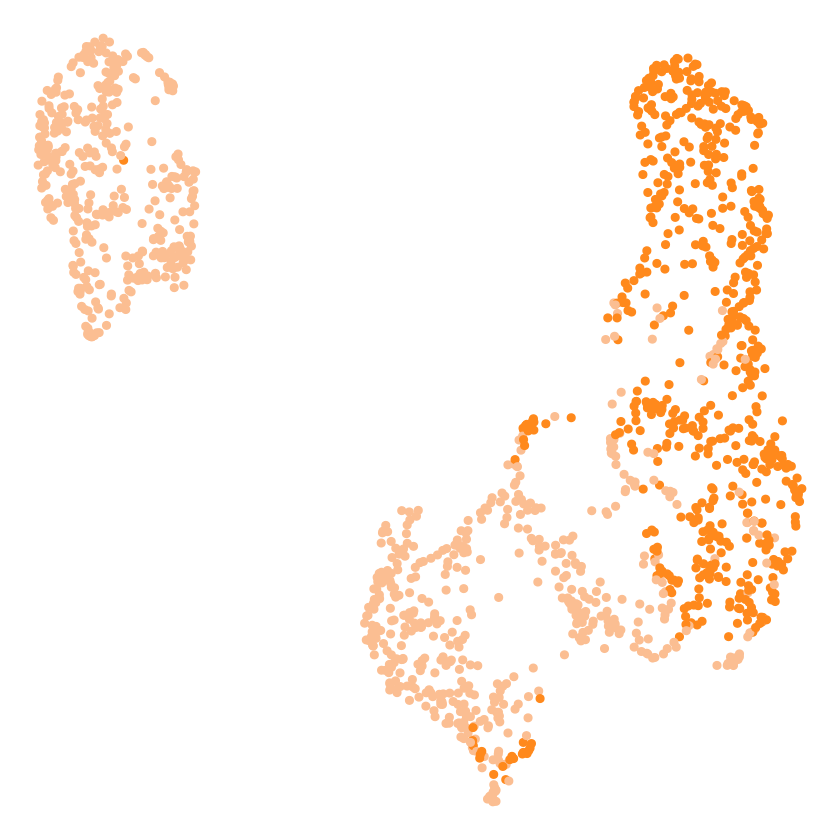

In [8]:
##########
## UMAP ##
##########

# W/O batch correction
set.seed(args$seed)
args$min_dist = 0.1
args$n_neighbors = 25

umap.mtx = umap(reducedDim(sce_filt, "PCA")[colnames(sce),], 
                n_neighbors = args$n_neighbors,
                min_dist = args$min_dist)

# Fetch UMAP coordinates
umap.dt <- umap.mtx %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell")) %>%
  merge(.,sample_metadata[,c('cell', 'celltype', 'stage')], by='cell')

# Plot umap
ggplot(umap.dt, aes(UMAP1, UMAP2, col=celltype)) + 
    geom_point() + 
    scale_colour_manual(values=opts$celltype.colors) + 
    theme_void() + 
    theme(legend.position="none")

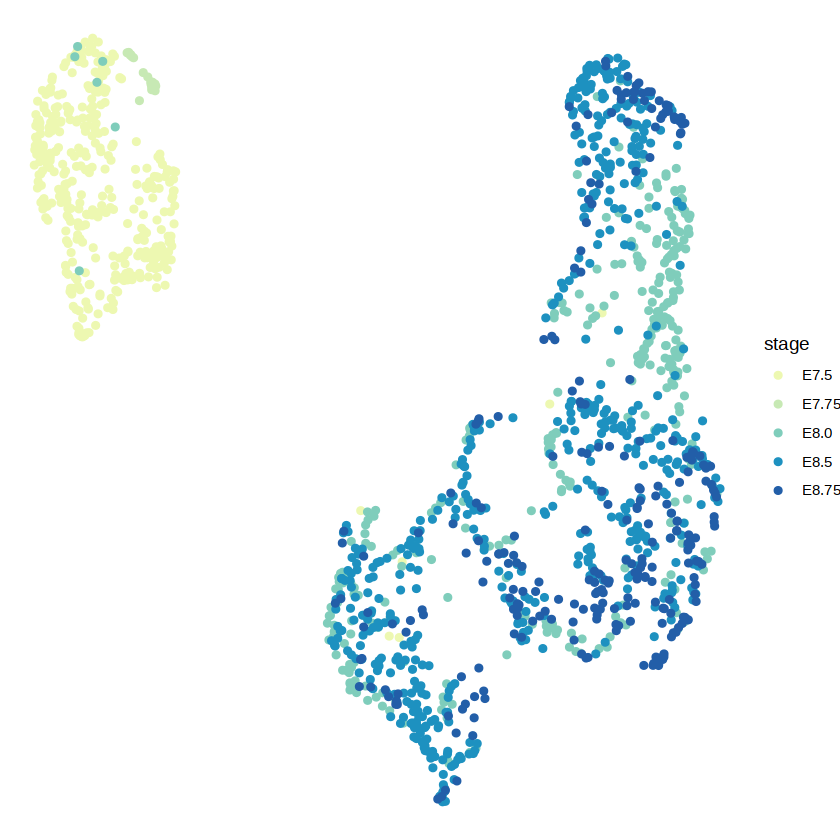

In [9]:


# Plot umap
ggplot(umap.dt, aes(UMAP1, UMAP2, col=stage)) + 
    geom_point() + 
    scale_colour_manual(values=opts$stage.colors) + 
    theme_void() + 
    theme(legend.position="right")

In [10]:
# clustering
# Create Seurat objct
library(Seurat)
seurat = as.Seurat(sce_filt)
set.seed(args$seed)

# Cluster
seurat <- FindNeighbors(seurat, 
                        reduction='PCA',
                        k.param = 20)

seurat <- FindClusters(seurat, 
                       resolution = 0.3,  
                       n.start = 10,
                       n.iter = 10)

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from PC to PC_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to PC_”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1579
Number of edges: 48259

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8828
Number of communities: 5
Elapsed time: 0 seconds


Warning message:
“No columnames present in cell embeddings, setting to 'umap_1:2'”


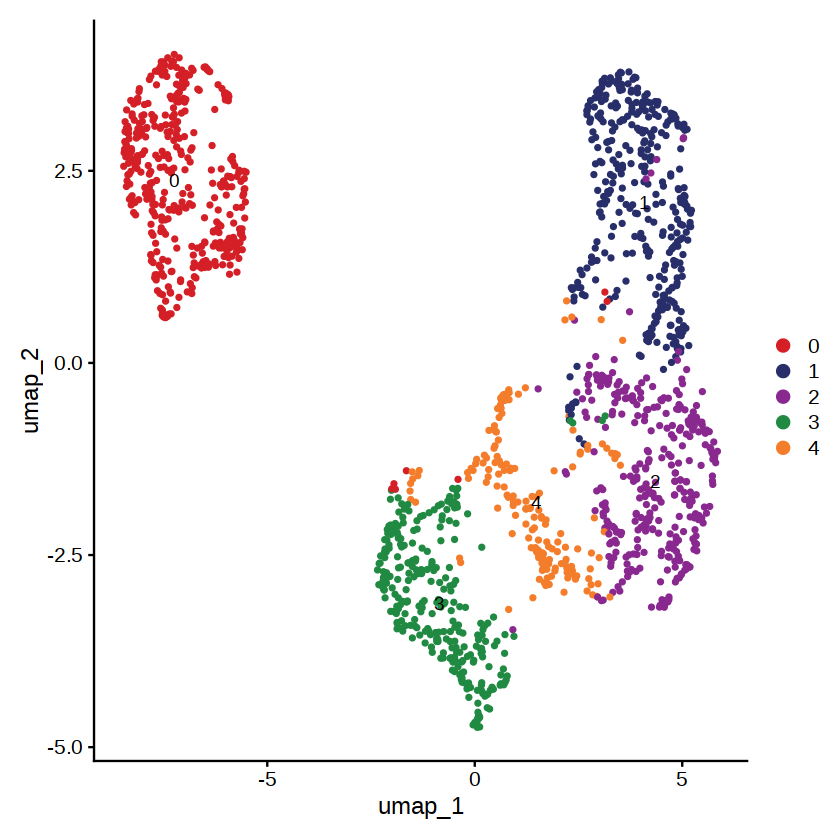

In [11]:
clusters = unique(seurat@meta.data$seurat_clusters)
colors = c(ArchR::ArchRPalettes$stallion, ArchR::ArchRPalettes$stallion2)[1:length(clusters)]
names(colors) = clusters

options(repr.plot.width=7, repr.plot.height=7)
seurat[["umap"]] <- CreateDimReducObject(embeddings = umap.mtx, key = "umap_", assay = DefaultAssay(seurat))
DimPlot(seurat, reduction = "umap",  label = TRUE) + 
    scale_color_manual(values = colors)

In [12]:
summary(colnames(seurat) == sample_metadata$cell)

   Mode    TRUE 
logical    1579 

In [13]:
markers = FindAllMarkers(seurat)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



In [17]:
markers %>% as.data.table() %>% .[, head(.SD, 5), by=cluster]

cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,2.806840e-177,0.7558926,1.000,0.955,8.420520e-174,Gm26917
0,6.353987e-173,-1.5940884,0.053,0.955,1.906196e-169,Hbb-bh1
0,4.439810e-162,0.4739314,1.000,1.000,1.331943e-158,Gm42418
0,1.839577e-159,0.8030901,0.993,0.873,5.518730e-156,Lars2
0,2.120795e-155,-0.7957689,0.864,0.997,6.362386e-152,Mest
1,1.525150e-143,1.2079872,0.798,0.153,4.575449e-140,Oit3
1,1.034556e-134,1.3667766,0.785,0.173,3.103667e-131,Mrc1
1,7.444760e-133,1.5281836,0.586,0.047,2.233428e-129,Lyve1
1,1.090821e-118,1.3442478,0.481,0.023,3.272464e-115,Stab2


In [18]:
options(repr.plot.width=5, repr.plot.height=5)
plot_gene = function(gene){
    umap.dt$gene = as.vector(logcounts(sce[gene,]))
    umap.dt = umap.dt[order(gene)]
    ggplot(umap.dt, aes(UMAP1, UMAP2, col=gene)) + 
        geom_point() + 
        scale_color_gradientn(colours = rev(rainbow(3)), name = gene) +
        theme_void() + 
        theme(legend.position="right")
}


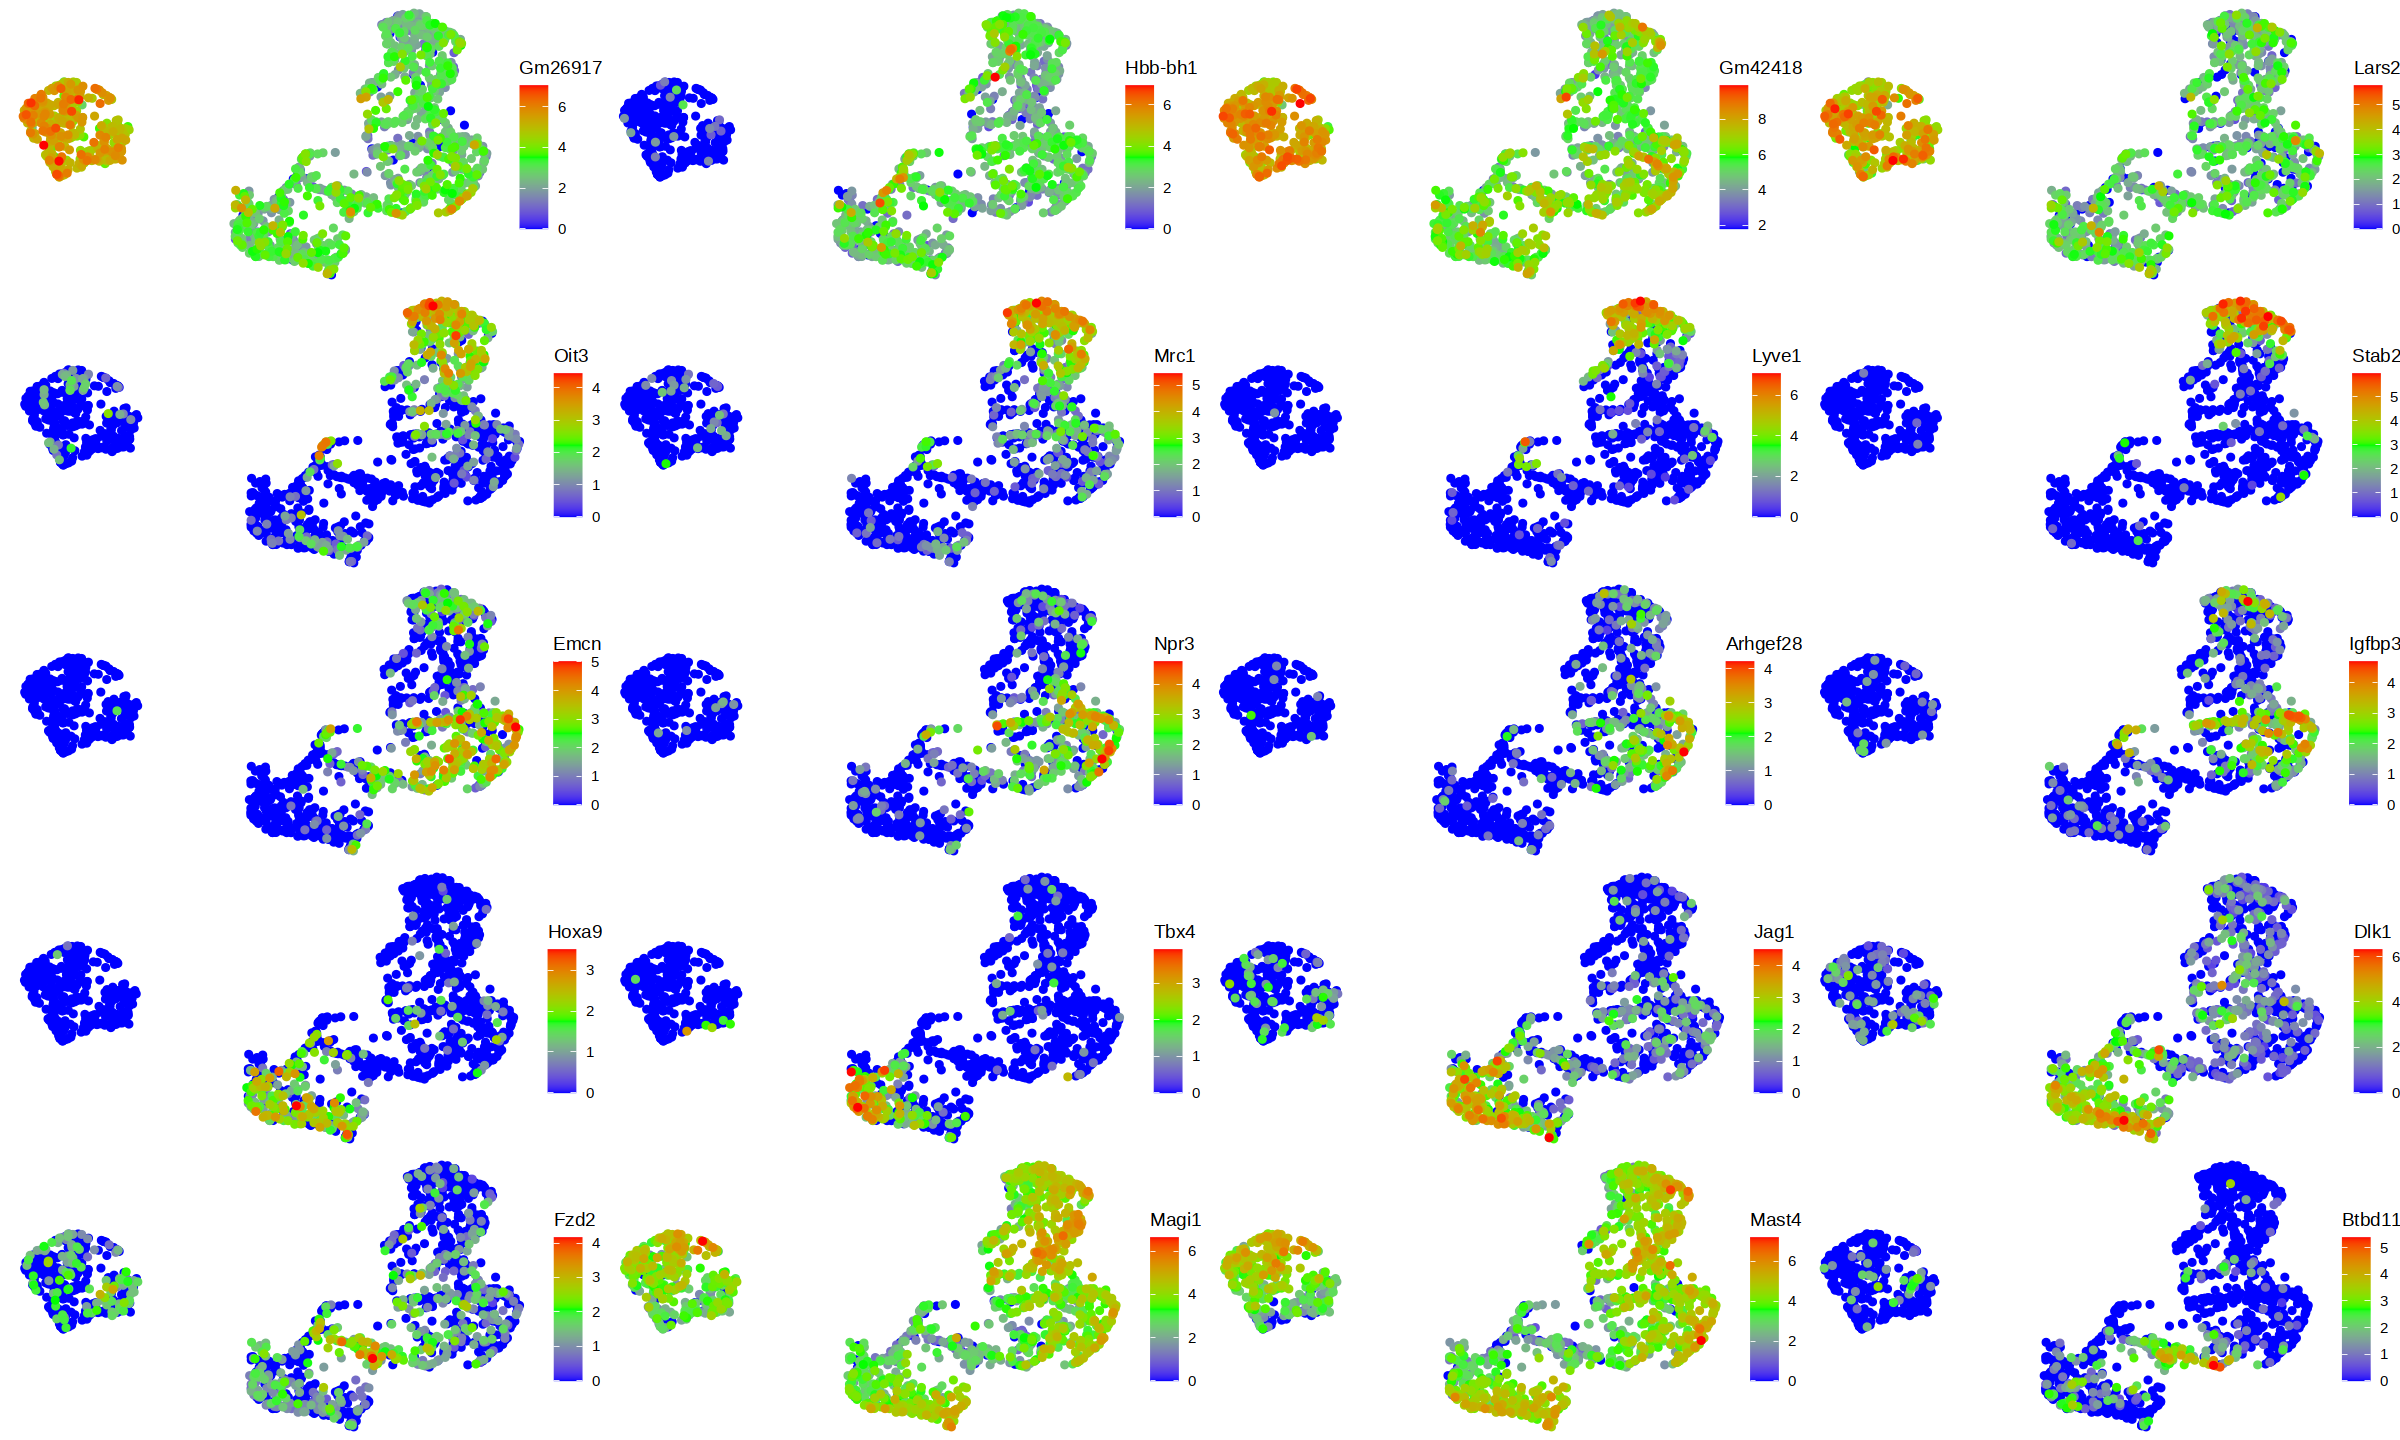

In [19]:
marker_genes = markers %>% as.data.table() %>% .[, head(.SD, 4), by=cluster] %>% .[order(cluster)] %>% .$gene
p = lapply(marker_genes, plot_gene)
options(repr.plot.width=20, repr.plot.height=12)
cowplot::plot_grid(plotlist=p, ncol=4)

In [14]:
sample_metadata$seurat_cluster = as.numeric(as.vector(Idents(seurat)))
replace = c('0' = 'EryP_progenitor',
            '1' = 'YS_endothelium',
            '2' = 'EP_endothelium',
            '3' = 'Allantois_endothelium',
            '4' = 'Unknown_endothelium'
           )
sample_metadata$seurat_cluster = str_replace_all(sample_metadata$seurat_cluster, replace)

In [16]:
summary(sample_metadata$cell == colnames(sce))

   Mode    TRUE 
logical    1579 

In [17]:
colData(sce) <- sample_metadata %>% as.data.frame %>% tibble::column_to_rownames("cell") %>%
  .[colnames(sce),] %>% DataFrame()

In [18]:
args$outdir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/endothelium"

In [ ]:
/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/endothelium/endothelium_sce.rds

In [19]:
saveRDS(sce, file.path(args$outdir, 'endothelium_sce.rds'))

### Export browser tracks for clusters

In [20]:
suppressPackageStartupMessages(library(ArchR))


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [21]:
ArchRProject <- loadArchRProject(io$archR.directory)[sample_metadata$cell]

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [22]:
summary(colnames(seurat) == rownames(ArchRProject@cellColData))

   Mode    TRUE 
logical    1579 

In [23]:
summary(names(Idents(seurat)) == rownames(ArchRProject@cellColData))

   Mode    TRUE 
logical    1579 

In [24]:
sample_metadata$seurat_cluster = as.numeric(as.vector(Idents(seurat)))

In [25]:
replace = c('0' = 'EryP_progenitor',
            '1' = 'YS_endothelium',
            '2' = 'EP_endothelium',
            '3' = 'Allantois_endothelium',
            '4' = 'Unknown_endothelium'
           )
sample_metadata$seurat_cluster = str_replace_all(sample_metadata$seurat_cluster, replace)

In [26]:
ArchRProject <- addCellColData(ArchRProj = ArchRProject, 
                                    data = sample_metadata$seurat_cluster,
                                    cells = sample_metadata$cell,
                                    name = "cluster",
                                    force=TRUE)

In [164]:
# Export genome browser tracks
addArchRThreads(24)
getGroupBW(
  ArchRProj = ArchRProject,
  groupBy = 'cluster',
  normMethod = c("ReadsInTSS"),
  tileSize = 100,
  maxCells = 1000, # default
  ceiling = 4
)

Setting default number of Parallel threads to 24.

ArchR logging to : ArchRLogs/ArchR-getGroupBW-3c37c22ddb37c-Date-2024-02-21_Time-17-32-10.log
If there is an issue, please report to github with logFile!

2024-02-21 17:32:25 : Allantois_endothelium (1 of 5) : Creating BigWig for Group, 0.238 mins elapsed.

2024-02-21 17:33:36 : EP_endothelium (2 of 5) : Creating BigWig for Group, 1.423 mins elapsed.

2024-02-21 17:34:06 : EryP_progenitor (3 of 5) : Creating BigWig for Group, 1.926 mins elapsed.

2024-02-21 17:34:33 : Unknown_endothelium (4 of 5) : Creating BigWig for Group, 2.375 mins elapsed.

2024-02-21 17:34:49 : YS_endothelium (5 of 5) : Creating BigWig for Group, 2.643 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-getGroupBW-3c37c22ddb37c-Date-2024-02-21_Time-17-32-10.log



[1] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/data/processed/atac/archR/GroupBigWigs/cluster/Allantois_endothelium-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"
[2] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/data/processed/atac/archR/GroupBigWigs/cluster/EP_endothelium-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"       
[3] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/data/processed/atac/archR/GroupBigWigs/cluster/EryP_progenitor-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"      
[4] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/data/processed/atac/archR/GroupBigWigs/cluster/Unknown_endothelium-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"  
[5] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/data/processed/atac/archR/GroupBigWigs/cluster/YS_endothelium-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"

#### Find differential peaks

In [27]:
unique(sample_metadata$seurat_cluster)

[1] "EryP_progenitor"       "YS_endothelium"        "Allantois_endothelium"
[4] "EP_endothelium"        "Unknown_endothelium"

In [28]:
# First remove EryP progenitors
meta_subset = sample_metadata[seurat_cluster != 'EryP_progenitor']
ArchRProject = ArchRProject[meta_subset$cell]

In [29]:
# Differential peaks one v all
markersPeaks <- getMarkerFeatures(
    ArchRProj = ArchRProject, 
    testMethod = "wilcoxon",
    binarize = FALSE,
    useMatrix = "PeakMatrix",
    groupBy = "cluster",
    verbose = F
)


ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-2bd484f6d86d7-Date-2024-02-23_Time-17-34-09.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

Pairwise Test Allantois_endothelium : Seqnames chr1

Pairwise Test Allantois_endothelium : Seqnames chr10

Pairwise Test Allantois_endothelium : Seqnames chr11

Pairwise Test Allantois_endothelium : Seqnames chr12

Pairwise Test Allantois_endothelium : Seqnames chr13

Pairwise Test Allantois_endothelium : Seqnames chr14

Pairwise Test Allantois_endothelium : Seqnames chr15

Pairwise Test Allantois_endothelium : Seqnames chr16

Pairwise Test Allantois_endothelium : Seqnames chr17

Pairwise Test Allantois_endothelium : Seqnames chr18

Pairwise Test Allantois_endothelium : Seqnames chr19

Pairwise Test Allantois_endothelium : Seqnames chr2

Pairwise Test Allantois_endothelium : Seqnames chr3

Pairwise Test Allantois_endothelium : Seqnames chr4

Pairwise Test Allantois_endothelium : Seqnames ch

In [30]:
markerList <- as.data.table(getMarkers(markersPeaks, cutOff = "FDR <= 0.01 & Log2FC >= 1"))[,region:=paste0(seqnames, ':', start-20000 ,'-', end+20000)]


In [31]:
markerList[order(-Log2FC)] %>% .[, head(.SD, 4), by=group_name]

group_name,group,seqnames,idx,start,end,Log2FC,FDR,MeanDiff,region
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Allantois_endothelium,1,chr2,6353,79291653,79292253,5.104143,3.231876e-09,0.16900442,chr2:79271653-79312253
Allantois_endothelium,1,chr7,8762,119390708,119391308,4.975095,8.392787e-09,0.14398966,chr7:119370708-119411308
Allantois_endothelium,1,chr9,4653,60351008,60351608,4.823607,3.377268e-08,0.11774655,chr9:60331008-60371608
Allantois_endothelium,1,chr2,8168,110134730,110135330,4.779243,9.402530e-08,0.11405033,chr2:110114730-110155330
YS_endothelium,4,chr15,1092,28047617,28048217,4.558987,3.353750e-04,0.09556024,chr15:28027617-28068217
YS_endothelium,4,chr9,9451,111188610,111189210,3.810228,6.099505e-04,0.14165039,chr9:111168610-111209210
YS_endothelium,4,chr8,2640,39300545,39301145,3.448237,6.175814e-03,0.11327615,chr8:39280545-39321145
YS_endothelium,4,chr1,7085,131025294,131025894,3.255645,5.011586e-03,0.16231981,chr1:131005294-131045894
EP_endothelium,2,chr4,189,8361170,8361770,3.979605,1.667159e-06,0.14224277,chr4:8341170-8381770


In [41]:
getwd()

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/code/Endothelium"

In [43]:
fwrite(markerList, file.path(getwd(), 'Endothelial_subset_markers.txt'))

In [32]:
head(markerList[group_name =='Allantois_endothelium'][order(-Log2FC)], 10)

group,group_name,seqnames,idx,start,end,Log2FC,FDR,MeanDiff,region
<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,Allantois_endothelium,chr2,6353,79291653,79292253,5.104143,3.231876e-09,0.1690044,chr2:79271653-79312253
1,Allantois_endothelium,chr7,8762,119390708,119391308,4.975095,8.392787e-09,0.1439897,chr7:119370708-119411308
1,Allantois_endothelium,chr9,4653,60351008,60351608,4.823607,3.377268e-08,0.1177466,chr9:60331008-60371608
1,Allantois_endothelium,chr2,8168,110134730,110135330,4.779243,9.402530e-08,0.1140503,chr2:110114730-110155330
1,Allantois_endothelium,chr1,6134,106109180,106109780,4.724708,3.079229e-10,0.1949500,chr1:106089180-106129780
1,Allantois_endothelium,chr10,4225,67625659,67626259,4.711498,7.529988e-09,0.1086209,chr10:67605659-67646259
1,Allantois_endothelium,chr2,437,9574099,9574699,4.707324,1.542109e-07,0.1082947,chr2:9554099-9594699
1,Allantois_endothelium,chr12,4162,77201429,77202029,4.500825,5.465821e-09,0.1188325,chr12:77181429-77222029
1,Allantois_endothelium,chr1,6276,116043993,116044593,4.479513,2.662424e-15,0.2707103,chr1:116023993-116064593


In [33]:
markerList <- as.data.table(getMarkers(markersPeaks, cutOff = "FDR <= 0.01 & Log2FC <= -1"))[,region:=paste0(seqnames, ':', start-20000 ,'-', end+20000)]
head(markerList[group_name =='Allantois_endothelium'][order(Log2FC)], 10)

group,group_name,seqnames,idx,start,end,Log2FC,FDR,MeanDiff,region
<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,Allantois_endothelium,chr10,1997,37483479,37484079,-4.752242,4.085691e-08,-0.13990262,chr10:37463479-37504079
1,Allantois_endothelium,chr2,6395,79983177,79983777,-4.265540,9.551691e-06,-0.09220843,chr2:79963177-80003777
1,Allantois_endothelium,chr3,6542,108786482,108787082,-4.147801,6.611420e-05,-0.08384454,chr3:108766482-108807082
1,Allantois_endothelium,chr11,1016,17004826,17005426,-4.100769,2.688734e-04,-0.08160871,chr11:16984826-17025426
1,Allantois_endothelium,chr1,3473,67321760,67322360,-4.076052,4.866514e-04,-0.10722742,chr1:67301760-67342360
1,Allantois_endothelium,chr12,4969,83947002,83947602,-3.857801,3.841710e-07,-0.13307823,chr12:83927002-83967602
1,Allantois_endothelium,chr5,8721,122109038,122109638,-3.828592,1.932303e-05,-0.10101898,chr5:122089038-122129638
1,Allantois_endothelium,chr4,6269,114663970,114664570,-3.793625,2.078367e-03,-0.05546292,chr4:114643970-114684570
1,Allantois_endothelium,chr14,7430,121985899,121986499,-3.777993,1.326451e-03,-0.05481875,chr14:121965899-122006499


Warning message:
“'markerHeatmap' is deprecated.
Use 'plotMarkerHeatmap' instead.
See help("Deprecated")”
ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-2bd4811720b96-Date-2024-02-23_Time-17-37-28.log
If there is an issue, please report to github with logFile!

Identified 9712 markers!



 [1] "chr1:4543939-4544539"      "chr1:4615242-4615842"     
 [3] "chr1:5108444-5109044"      "chr1:5109050-5109650"     
 [5] "chr1:6022642-6023242"      "chr1:6132851-6133451"     
 [7] "chr1:6188310-6188910"      "chr1:7971162-7971762"     
 [9] "chr1:9627040-9627640"      "chr1:9755494-9756094"     
[11] "chr1:9847961-9848561"      "chr1:9859033-9859633"     
[13] "chr1:10123915-10124515"    "chr1:10226753-10227353"   
[15] "chr1:10285375-10285975"    "chr1:4426802-4427402"     
[17] "chr1:4602246-4602846"      "chr1:4653787-4654387"     
[19] "chr1:12718327-12718927"    "chr1:12748393-12748993"   
[21] "chr1:12749019-12749619"    "chr1:12753818-12754418"   
[23] "chr1:13655439-13656039"    "chr1:16177494-16178094"   
[25] "chr1:16293733-16294333"    "chr1:17033683-17034283"   
[27] "chr1:20817211-20817811"    "chr1:20995461-20996061"   
[29] "chr1:20996507-20997107"    "chr1:21014348-21014948"   
[31] "chr1:15892402-15893002"    "chr1:167599112-167599712" 
[33] "chr11:4757314-4757

Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-2bd4811720b96-Date-2024-02-23_Time-17-37-28.log



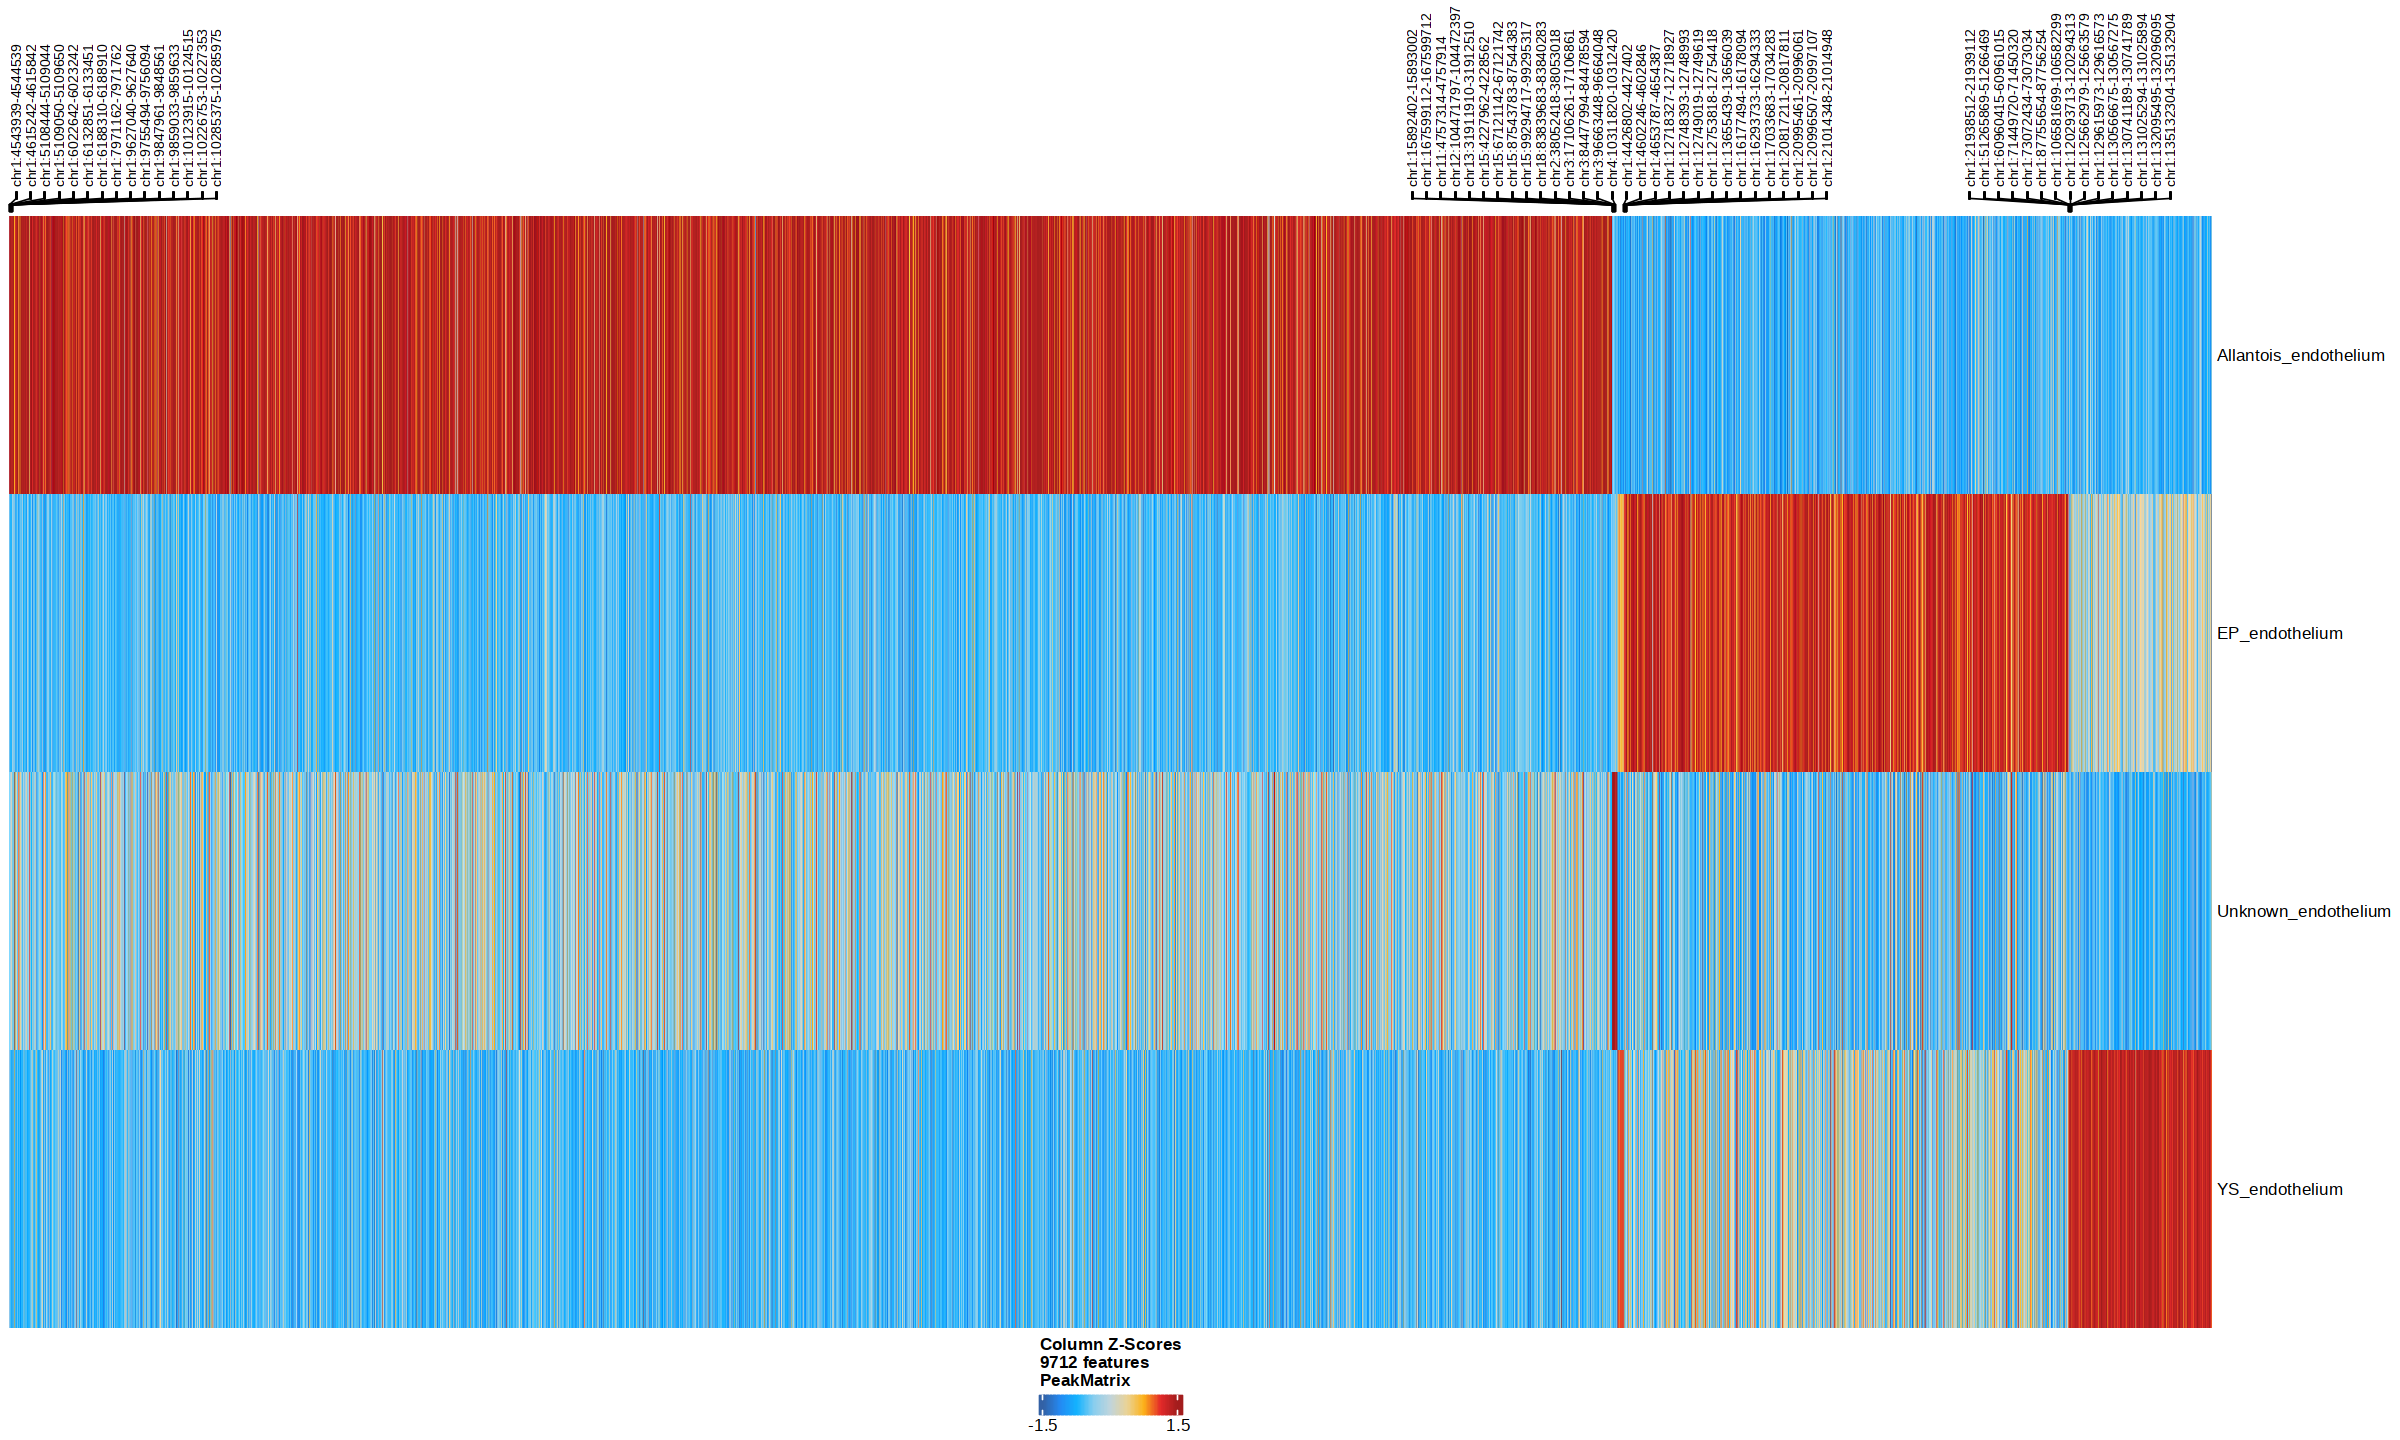

In [34]:
heatmapPeaks <- markerHeatmap(
  seMarker = markersPeaks, 
  cutOff = "FDR <= 0.1 & Log2FC >= 0.5",
  transpose = TRUE
)
draw(heatmapPeaks, heatmap_legend_side = "bot", annotation_legend_side = "bot")

In [35]:
library(BSgenome.Mmusculus.UCSC.mm10)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.3”


In [36]:
ArchRProject <- addMotifAnnotations(ArchRProj = ArchRProject, motifSet = "cisbp", name = "Motif")

ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-2bd4817d6c77b-Date-2024-02-23_Time-17-37-57.log
If there is an issue, please report to github with logFile!

2024-02-23 17:38:05 : Gettting Motif Set, Species : Mus musculus, 0.005 mins elapsed.

Using version 2 motifs!

2024-02-23 17:38:08 : Finding Motif Positions with motifmatchr!, 0.053 mins elapsed.

2024-02-23 17:42:07 : All Motifs Overlap at least 1 peak!, 4.032 mins elapsed.

2024-02-23 17:42:07 : Creating Motif Overlap Matrix, 4.032 mins elapsed.

2024-02-23 17:42:10 : Finished Getting Motif Info!, 4.081 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addMotifAnnotations-2bd4817d6c77b-Date-2024-02-23_Time-17-37-57.log



In [37]:
plot_enr_heatmap = function(enrichMotifs, ntop=25) {
    heatmapEM <- plotEnrichHeatmap(enrichMotifs, n = ntop, returnMatrix = TRUE)

    enriched.dt = melt(as.data.table(heatmapEM, keep.rownames=T) %>% setnames('rn', 'TF'), id.vars = c("TF")) %>%
        .[order(-value)] %>% .[,TF:=strsplit(TF, '_') %>% map_chr(1)]

    keep_tfs = enriched.dt  %>% .[order(variable)] %>% .[, head(.SD, ntop),  by=variable] %>% .$TF   
    enriched.dt = enriched.dt[TF %in% keep_tfs] %>% .[order( -value)] %>% 
        #.[,TF:=strsplit(TF, '_') %>% map_chr(1)] %>%
         .[,TF:=factor(TF, levels=unique(keep_tfs))] #%>%
       # .[,variable:=factor(variable, levels=cluster_levels)]
    
    p = ggplot(enriched.dt, aes(TF, variable, fill=value)) + 
        geom_tile(col='black') +
        scale_fill_gradient(low='white', high='darkblue', name='Norm. Enrichment -log10(P-adj) [0-max]') +
        theme_void() + theme(text=element_text(size=15), 
                             axis.text.x=element_text(angle=-90,hjust=0,vjust=0.5, size=15), 
                             axis.text.y=element_text(hjust=0),
                            legend.position='bottom')
p
    return(p)
}




ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-2bd481fe9a613-Date-2024-02-23_Time-17-42-12.log
If there is an issue, please report to github with logFile!

2024-02-23 17:42:18 : Computing Enrichments 1 of 4, 0.103 mins elapsed.

2024-02-23 17:42:19 : Computing Enrichments 2 of 4, 0.111 mins elapsed.

2024-02-23 17:42:19 : Computing Enrichments 3 of 4, 0.122 mins elapsed.

2024-02-23 17:42:20 : Computing Enrichments 4 of 4, 0.129 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-2bd481fe9a613-Date-2024-02-23_Time-17-42-12.log

ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-2bd485a604763-Date-2024-02-23_Time-17-42-20.log
If there is an issue, please report to github with logFile!



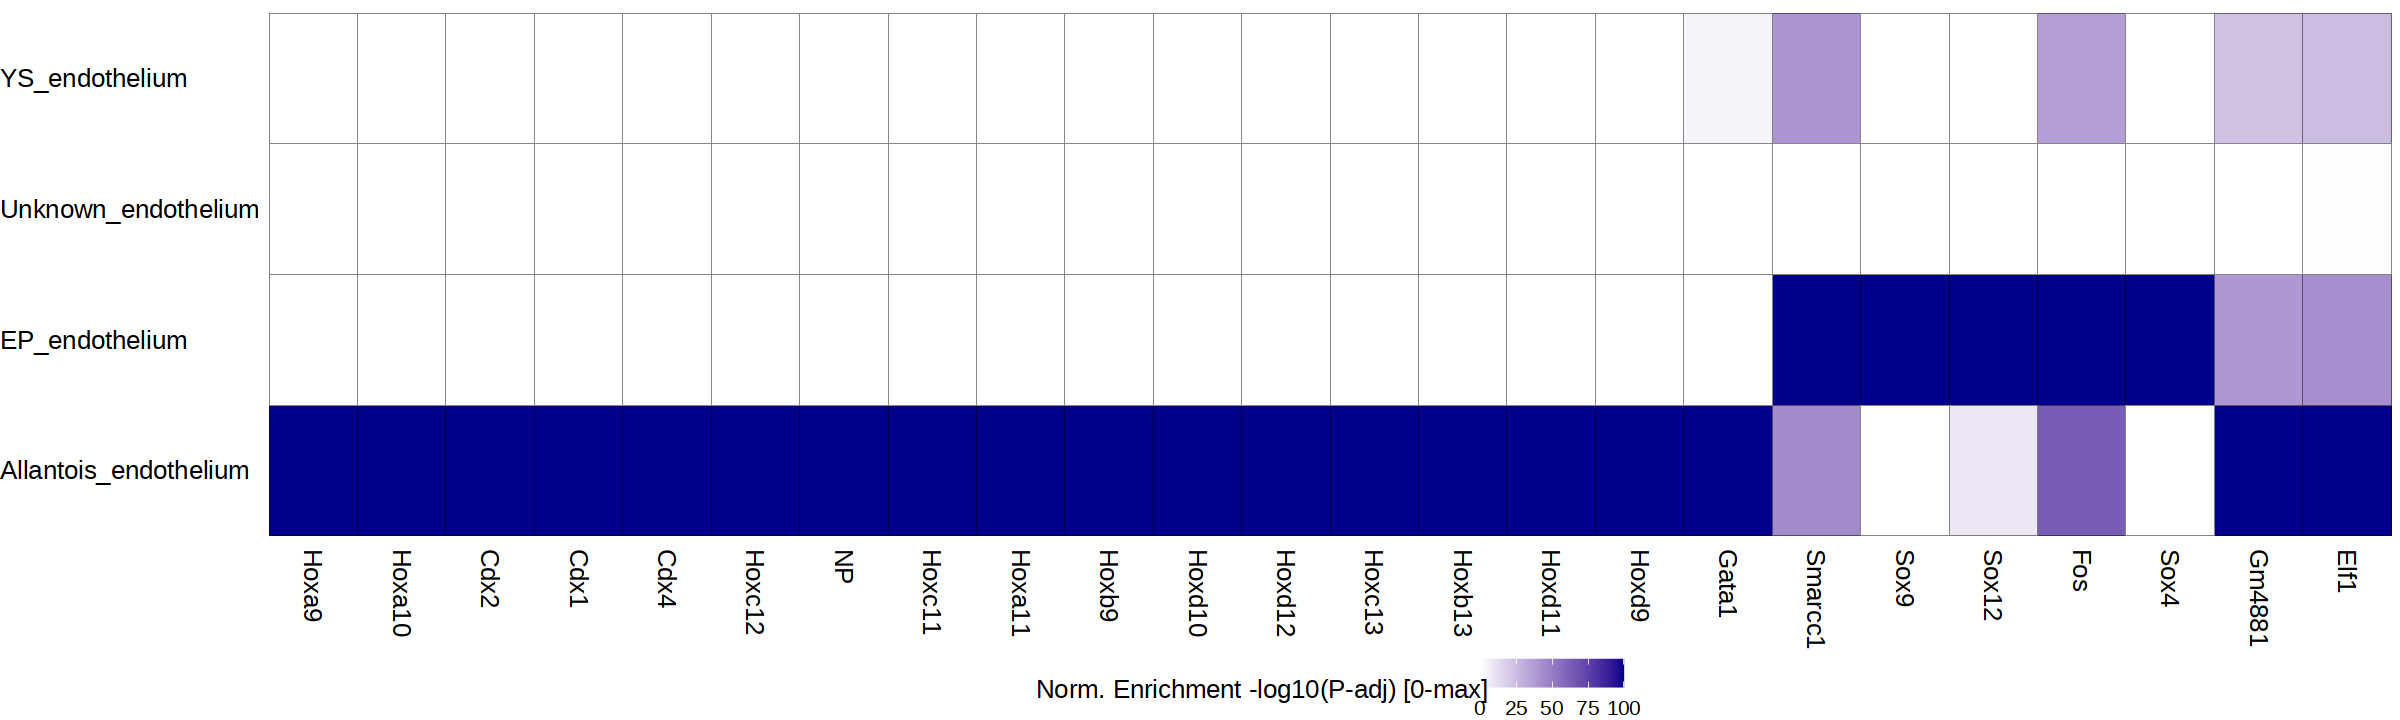

In [38]:
enrichMotifs <- peakAnnoEnrichment(
    seMarker = markersPeaks,
    ArchRProj = ArchRProject,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.05 & Log2FC >= 0.4"
  )
options(repr.plot.width=20, repr.plot.height=6)
plot_enr_heatmap(enrichMotifs, ntop = 20)

ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-2bd48389ffb8-Date-2024-02-23_Time-17-42-21.log
If there is an issue, please report to github with logFile!

2024-02-23 17:42:27 : Computing Enrichments 1 of 4, 0.102 mins elapsed.

2024-02-23 17:42:28 : Computing Enrichments 2 of 4, 0.11 mins elapsed.

2024-02-23 17:42:28 : Computing Enrichments 3 of 4, 0.117 mins elapsed.

2024-02-23 17:42:29 : Computing Enrichments 4 of 4, 0.126 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-2bd48389ffb8-Date-2024-02-23_Time-17-42-21.log

ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-2bd486175f044-Date-2024-02-23_Time-17-42-29.log
If there is an issue, please report to github with logFile!



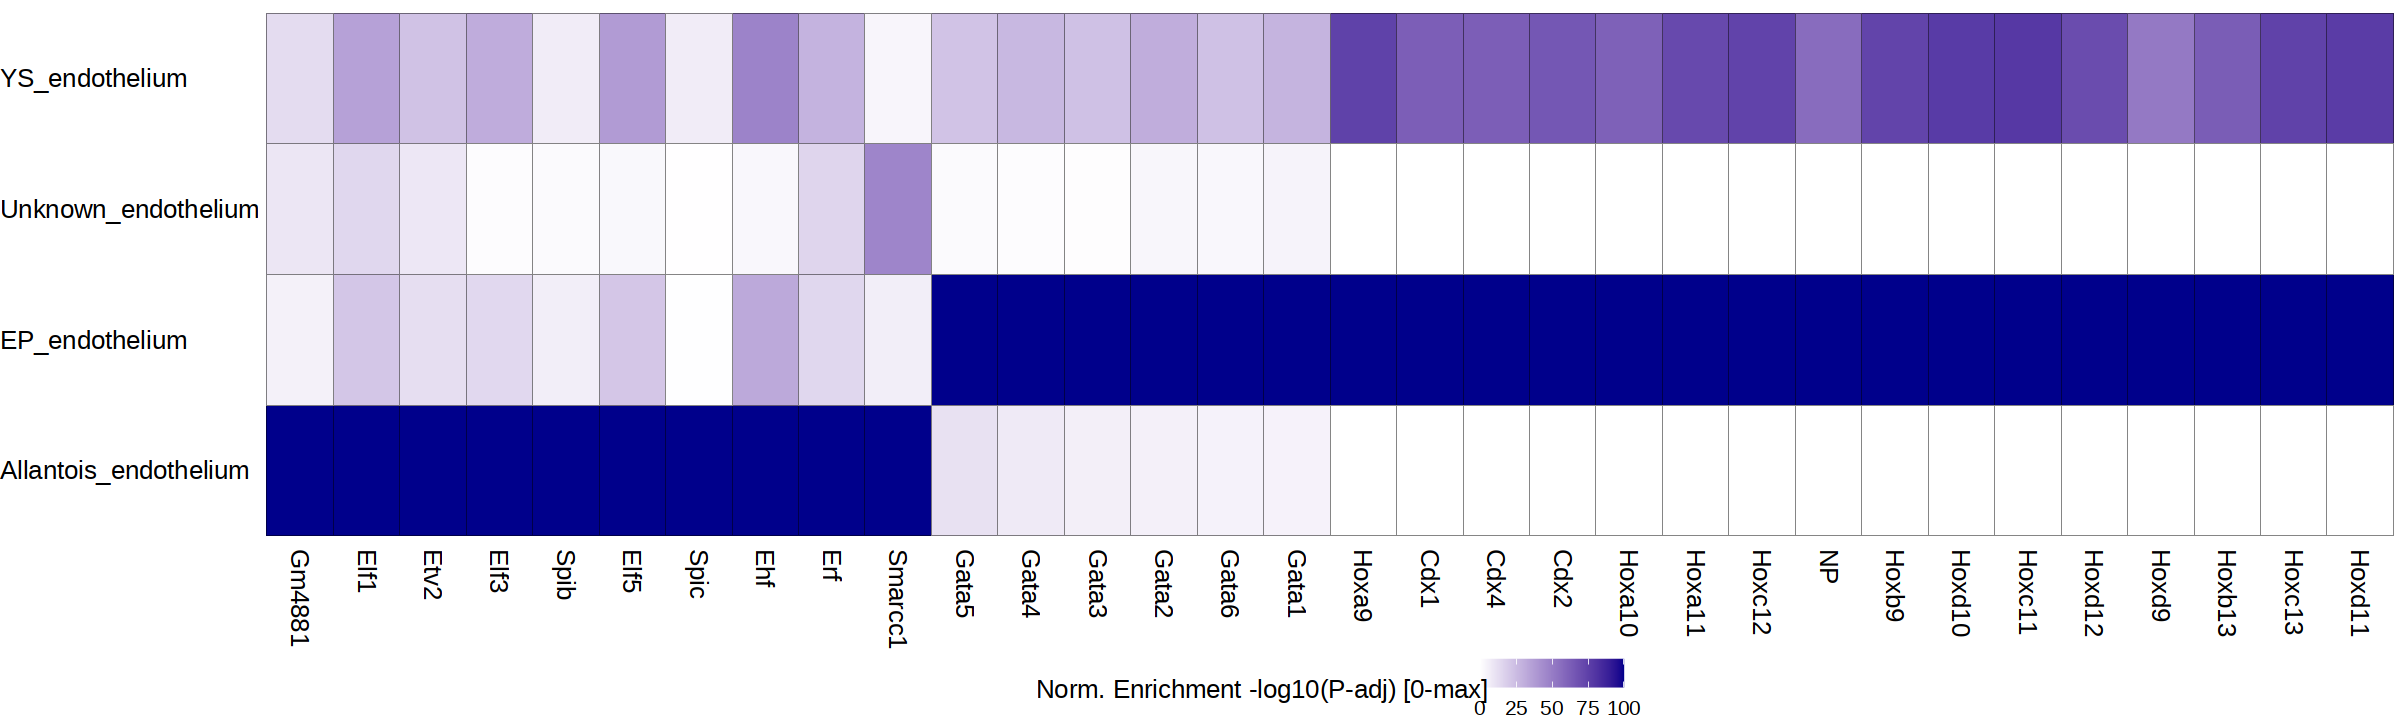

In [39]:
enrichMotifs <- peakAnnoEnrichment(
    seMarker = markersPeaks,
    ArchRProj = ArchRProject,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.05 & Log2FC <= -0.4"
  )

options(repr.plot.width=20, repr.plot.height=6)
plot_enr_heatmap(enrichMotifs, ntop = 25)

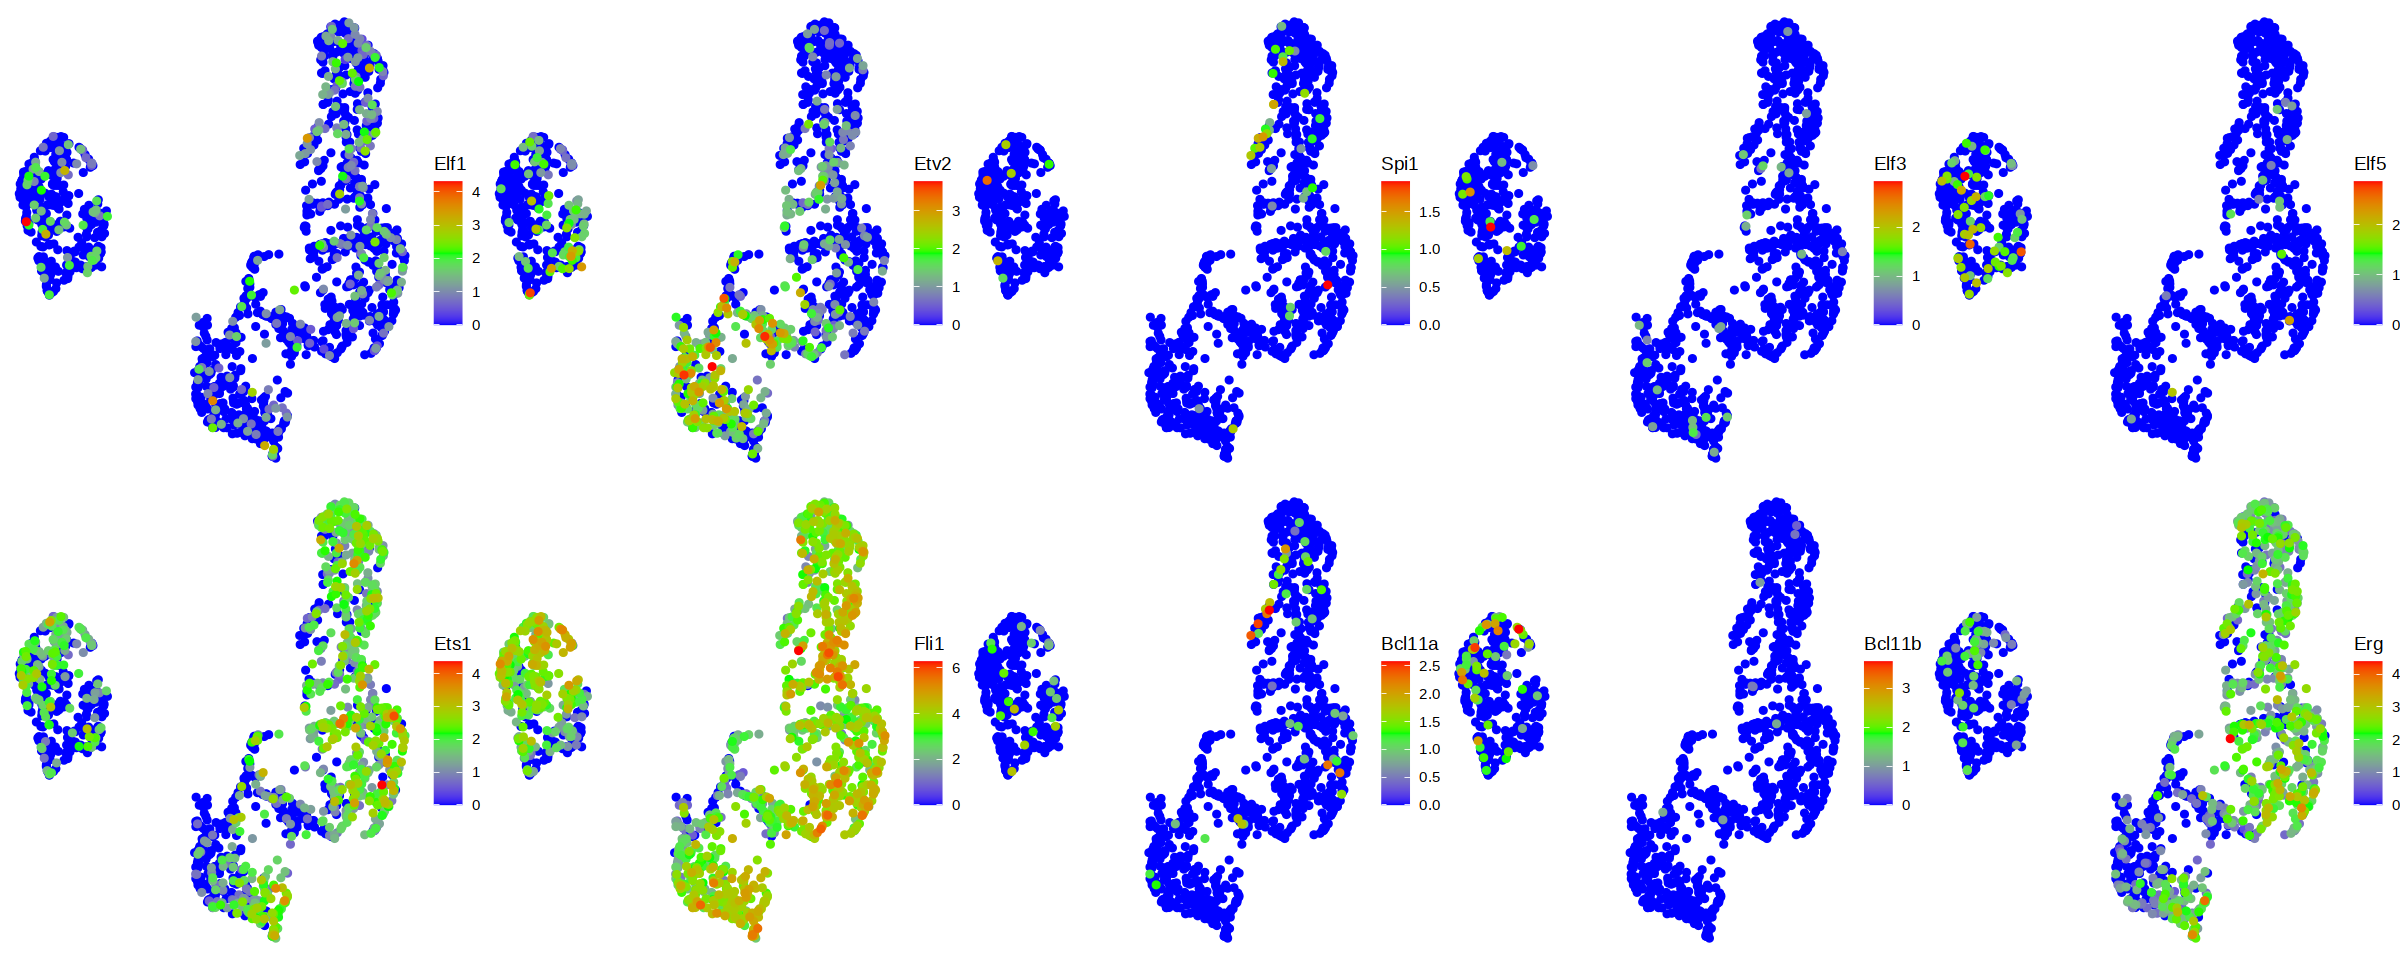

In [40]:
p = lapply(c('Elf1', 'Etv2', 'Spi1', 'Elf3', 'Elf5', 'Ets1', 'Fli1', 'Bcl11a', 'Bcl11b', 'Erg'), plot_gene)
options(repr.plot.width=20, repr.plot.height=8)
cowplot::plot_grid(plotlist=p, ncol=5)

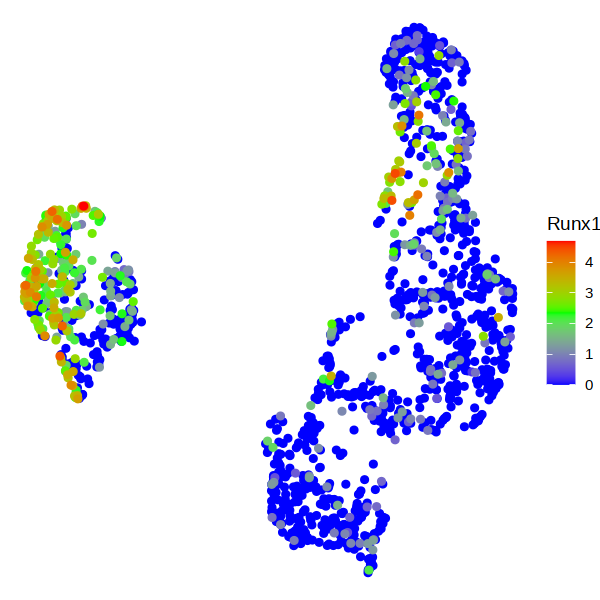

In [217]:
options(repr.plot.width=5, repr.plot.height=5)
plot_gene('Runx1')